In [2]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import date
from datetime import *; from dateutil.relativedelta import *
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
np.set_printoptions(suppress=True)

In [3]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

In [4]:
client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod', credentials=credentials)

In [18]:
#add code for `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
#data last updated on 08/04/2022


# sql = """
# with base as
#         (select order_date,
#                 top_channel,
#                 second_channel,
#                 #third_channel,
#                 #utm_campaign,
#                 #utm_medium,
#                 mapped_region,
#       sum(attr_gms) AS attr_gms,
#       sum(attr_receipt) as attr_receipt,
#       #sum(attr_rev) as attr_rev,
#       sum(chargeable_attr_gms) as chargeable_attr_gms,
#       sum(chargeable_attr_receipt) as chargeable_attr_receipt,
#       #sum(chargeable_attr_rev) as chargeable_attr_rev,
#       sum(chargeable_gms) as chargeable_gms,
#       sum(chargeable_receipts) as chargeable_receipts,
#       sum(advertising_revenue) as advertising_revenue
#       from `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
#       group by 1,2,3,4)
# SELECT * EXCEPT (order_date) ,
# '' as flag,
# order_date
# FROM base osa
# UNION ALL
# SELECT * EXCEPT (order_date) ,
# '_dly' as flag,
# datetime_add(osa.order_date, interval 52 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 52 WEEK) < CAST(current_date() as DATETIME)
# union all
# SELECT * EXCEPT (order_date) ,
# '_d2ly' as flag,
# datetime_add(osa.order_date, interval 104 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 104 WEEK) < CAST(current_date() as DATETIME)
# union all
# SELECT * EXCEPT (order_date) ,
# '_d3ly' as flag,
# datetime_add(osa.order_date, interval 156 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 156 WEEK) < CAST(current_date() as DATETIME)
# """

sql = """
with base as
        (select order_date,
        date_trunc(order_date, year) as order_year, 
        extract(week from order_date) as order_week_num, 
        extract(dayofyear from order_date) as order_dayofyear, 
      sum(attr_gms) AS attr_gms,
      sum(attr_receipt) as attr_receipt,
      sum(attr_rev) as attr_rev,
      sum(chargeable_attr_gms) as chargeable_attr_gms,
      sum(chargeable_attr_receipt) as chargeable_attr_receipt,
      sum(chargeable_attr_rev) as chargeable_attr_rev,
      sum(chargeable_gms) as chargeable_gms,
      sum(chargeable_receipts) as chargeable_receipts,
      sum(advertising_revenue) as advertising_revenue
      from `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
      left join `etsy-data-warehouse-prod.buyatt_mart.channel_dimensions` cd using (utm_campaign, utm_medium, top_channel, second_channel, third_channel)
      where order_date <= '2022-07-01'
      group by 1,2,3,4)
SELECT * EXCEPT (order_date) ,
'' as flag,
order_date
FROM base osa
UNION ALL
SELECT * EXCEPT (order_date) ,
'_dly' as flag,
datetime_add(osa.order_date, interval 52 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 52 WEEK) < CAST(current_date() as DATETIME)
union all
SELECT * EXCEPT (order_date) ,
'_d2ly' as flag,
datetime_add(osa.order_date, interval 104 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 104 WEEK) < CAST(current_date() as DATETIME)
union all
SELECT * EXCEPT (order_date) ,
'_d3ly' as flag,
datetime_add(osa.order_date, interval 156 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 156 WEEK) < CAST(current_date() as DATETIME)
"""

query_job = client.query(sql)
results = query_job.result()
base = results.to_dataframe()

In [19]:
base['order_date'] = pd.to_datetime(base['order_date']).dt.date
base['order_year'] = pd.to_datetime(base['order_year']).dt.date

base = pd.concat( [base[['order_date','flag']], base.drop(columns=['order_date','flag'])], axis = 1)

base.head()


,order_date,flag,order_year,order_week_num,order_dayofyear,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue
0,2022-04-18,_dly,2021-01-01,16,109,6351280.084887902,182203.670464161,1258127.404009862,2000407.529466956,48924.770082559,353366.803787592,3201326.230000000,307542,428357.100000000
1,2022-06-14,_dly,2021-01-01,24,166,5045492.362458506,151636.214277674,983886.689654220,1554452.208753420,40691.646249537,281641.372087502,2557517.610000000,251061,338974.720000000
2,2022-04-12,_dly,2021-01-01,15,103,6211318.234101295,178428.729526492,1243043.233573108,1965172.168211421,47833.612516749,353535.483722928,3171041.950000000,305916,424753.049999999
3,2022-04-03,_dly,2021-01-01,14,94,5354545.456207874,152201.724146284,1089572.312637970,1775904.159950616,42676.366282647,323271.317576201,2754715.070000000,261591,371044.410000000
4,2021-06-03,_dly,2020-01-01,22,156,4763846.167776940,169274.823850659,1007497.404784787,1571394.967009697,50052.060800237,296886.196308552,2488954.940000000,330878,345622.600000000


In [23]:
#add code for `etsy-data-warehouse-dev.tnormil.charge_lt_mta` 
#data last updated on 08/11/2022
#use this feature to predict chargeability pre May 2022 due to increased discreptancy between est receipts lt and mta and the truth values
#add link to validation charts

sql = """
with receipts_lt as
    (select date as order_date, date_trunc(date, year) as order_year,  extract(week from date) as order_week_num,  
    count(distinct case when attr_receipt_osa > 0 then receipt_id end) as receipts_lt
    FROM `etsy-data-warehouse-dev.tnormil.charge_lt_mta` 
    where charged_osa = 1 
    group by 1,2,3),
attr_receipt as
    (SELECT date as order_date, 
    sum(coalesce(attr_receipt_osa,0)) as attr_receipt_osa, 
    sum(coalesce(attr_receipt,0)) as attr_receipt,
    count(distinct receipt_id) as receipts_mta 
    FROM `etsy-data-warehouse-dev.tnormil.charge_lt_mta` 
    where charged_osa = 1 
    group by 1)  
select a.*, b.receipts_mta, '' as flag
#b.attr_receipt_osa, b.attr_receipt, 
from receipts_lt a
left join attr_receipt b using (order_date)
#where b.attr_receipt_osa <> b.attr_receipt;
"""

query_job = client.query(sql)
results = query_job.result()
base_lt_mta_ratio = results.to_dataframe()

In [24]:
base_lt_mta_ratio['order_date'] = pd.to_datetime(base_lt_mta_ratio['order_date']).dt.date
base_lt_mta_ratio['order_year'] = pd.to_datetime(base_lt_mta_ratio['order_year']).dt.date

base_lt_mta_ratio.head()

,order_date,order_year,order_week_num,receipts_lt,receipts_mta,flag
0,2021-06-08,2021-01-01,23,64119,64135,
1,2020-04-17,2020-01-01,15,94926,94935,
2,2020-09-07,2020-01-01,36,71275,71278,
3,2021-12-21,2021-01-01,51,64717,64812,
4,2020-11-03,2020-01-01,44,70916,71037,


In [25]:
sql = """
select '' as flag, case when charged_osa = 1 then 'osa_revenue' else 'none' end as charged_osa, date_trunc(date, year) as order_year,  extract(week from date) as order_week_num,
avg(attr_receipt) as attr_receipts, stddev(attr_receipt) as attributed_receipts_std
from `etsy-data-warehouse-dev.tnormil.charge_lt_mta` a
group by 1,2,3,4;
"""

query_job = client.query(sql)
results = query_job.result()
credit = results.to_dataframe()

#this is avg by receipt cross channel avg credit not the channel level

In [26]:
group_by_col = credit.loc[:,: 'order_week_num'].columns.values.tolist()

credit_base = pd.pivot_table(credit, values=['attr_receipts','attributed_receipts_std'], index=[item for item in group_by_col if item != 'charged_osa'],
                    columns=['charged_osa'])

credit_base.columns = credit_base.columns.map('_'.join).str.strip('_')

credit_base.reset_index(inplace=True)

In [27]:
credit_base.head()

,flag,order_year,order_week_num,attr_receipts_none,attr_receipts_osa_revenue,attributed_receipts_std_none,attributed_receipts_std_osa_revenue
0,,2020-01-01,0,0.410158311,0.244262265,0.317590293,NaN
1,,2020-01-01,1,0.342636366,NaN,0.302050800,NaN
2,,2020-01-01,2,0.299598375,0.205442693,0.291752044,0.074373300
3,,2020-01-01,3,0.273403396,0.038400784,0.286657450,0.000251145
4,,2020-01-01,4,0.264531178,0.112163294,0.291086189,0.065791451


In [28]:
sql = """
with base as 
(select *, case when date_diff(date, first_visit_date, DAY) <= 15 then '1 - 15' else '15+' end as days_since_purchase_type
from `etsy-data-warehouse-dev.tnormil.charge_lt_mta` )
select '' as flag, date as order_date, days_since_purchase_type, count(distinct receipt_id) as receipts, avg(date_diff(date, first_visit_date, DAY)) AS days_since_purchase, 
from base
group by 1,2,3
"""

query_job = client.query(sql)
results = query_job.result()
days_to_purch = results.to_dataframe()

In [29]:
metrics_index = (days_to_purch.columns.values.tolist()).index("receipts")
group_by_col = (days_to_purch.columns.values.tolist())[:metrics_index ]
metrics = (days_to_purch.columns.values.tolist())[metrics_index:]

print(group_by_col)
print(metrics)

days_to_purch[metrics] = days_to_purch[metrics].astype(float)

days_to_purch_base = pd.pivot_table(days_to_purch, values=['receipts','days_since_purchase'], index=[item for item in group_by_col if item != 'days_since_purchase_type'],
                    columns=['days_since_purchase_type'])

days_to_purch_base.columns = days_to_purch_base.columns.map('_'.join).str.strip('_')

days_to_purch_base.fillna(0, inplace=True)

days_to_purch_base['pct_receipts_1 - 15'] = days_to_purch_base['receipts_1 - 15']/(days_to_purch_base['receipts_1 - 15']+days_to_purch_base['receipts_15+'])

days_to_purch_base.drop(columns=['receipts_1 - 15','receipts_15+'], inplace=True)

days_to_purch_base.reset_index(inplace=True)

['flag', 'order_date', 'days_since_purchase_type']
['receipts', 'days_since_purchase']


In [30]:
days_to_purch_base.head()

,flag,order_date,days_since_purchase_1 - 15,days_since_purchase_15+,pct_receipts_1 - 15
0,,2020-01-01,0.000000000,0.000000000,1.000000000
1,,2020-01-02,0.276105281,0.000000000,1.000000000
2,,2020-01-03,0.587868753,0.000000000,1.000000000
3,,2020-01-04,0.892448467,0.000000000,1.000000000
4,,2020-01-05,1.229578413,0.000000000,1.000000000


In [36]:
sql = """
(with clicks as 
(select date(start_datetime) as date, count(visit_id) as visits 
from  `etsy-data-warehouse-prod.buyatt_mart.visits_vw` v 
left join `etsy-data-warehouse-prod.buyatt_mart.channel_dimensions` cd using (utm_campaign, utm_medium, top_channel, second_channel, third_channel)
where v._date >= '2020-01-01' 
and (v.second_channel IN(
'gpla', 'intl_gpla', 'facebook_disp', 'bing_plas', 'intl_bing_plas', 'pinterest_disp', 'pinterest_disp_intl','instagram_disp', 'facebook_disp_intl', 'affiliates'
) or (v.second_channel in ('native_display','intl_native_display') and third_channel not like '%msan%'))
and reporting_channel_group in ('PLA', 'Display', 'Paid Social', 'Affiliates') 
group by 1),
osa_el_clicks as 
(select date(timestamp_seconds(click_date)) as date,
count(click_id) as osa_el_clicks,
count(distinct listing_id) as osa_el_listings,
count(distinct shop_id) as osa_el_shops
from etsy-data-warehouse-prod.etsy_shard.ads_attribution_clicks 
group by 1)
select a.date, visits, osa_el_clicks, osa_el_listings, osa_el_shops
from clicks a
full outer join osa_el_clicks b using (date));
"""

query_job = client.query(sql)
results = query_job.result()
osa_el_clicks = results.to_dataframe()

In [39]:
osa_el_clicks_base = osa_el_clicks.copy()

osa_el_clicks_base['flag'] = ''
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

metrics = osa_el_clicks_base.select_dtypes(include=numerics).columns

for i in metrics:
    
    if i != 'visits':
        osa_el_clicks_base['visits_' + i] = osa_el_clicks_base['visits']/osa_el_clicks_base[i]

osa_el_clicks_base.drop(columns=metrics,inplace=True)

osa_el_clicks_base.rename({'date': 'order_date'}, axis=1, inplace=True)

osa_el_clicks_base.head()

,order_date,flag,visits_osa_el_clicks,visits_osa_el_listings,visits_osa_el_shops
0,2020-07-19,,1.130329123,3.951314956,15.624876389
1,2021-08-22,,0.998721205,3.361448082,14.483788887
2,2022-03-13,,0.994157582,3.803711849,16.704420661
3,2021-02-06,,1.151728681,4.040228496,17.210762651
4,2020-09-21,,1.123314476,3.967600107,15.950202541


In [42]:
base_ratio = base.merge(base_lt_mta_ratio, on=['flag', 'order_date','order_year','order_week_num'], how="outer")

base_ratio = base_ratio.merge(credit_base, on=['flag', 'order_year','order_week_num'], how="outer")

base_ratio = base_ratio.merge(days_to_purch_base, on=['flag', 'order_date'], how="outer")

base_ratio = base_ratio.merge(osa_el_clicks_base, on=['flag', 'order_date'], how="outer")

base_ratio.head()

,order_date,flag,order_year,order_week_num,order_dayofyear,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,receipts_lt,receipts_mta,attr_receipts_none,attr_receipts_osa_revenue,attributed_receipts_std_none,attributed_receipts_std_osa_revenue,days_since_purchase_1 - 15,days_since_purchase_15+,pct_receipts_1 - 15,visits_osa_el_clicks,visits_osa_el_listings,visits_osa_el_shops
0,2022-04-18,_dly,2021-01-01,16,109,6351280.084887902,182203.670464161,1258127.404009862,2000407.529466956,48924.770082559,353366.803787592,3201326.230000000,307542,428357.100000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
1,2022-04-21,_dly,2021-01-01,16,112,6064382.585727258,176369.720037320,1195858.316582234,1839813.155101464,45975.854249664,329628.346229044,3002468.400000000,305769,401232.080000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
2,2022-04-20,_dly,2021-01-01,16,111,6108941.529502481,177932.212971226,1204828.251285824,1859381.870309419,46497.947788990,331430.461678729,3037580.290000000,312932,406711.130000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
3,2022-04-17,_dly,2021-01-01,16,108,6543334.801846007,184601.313119547,1307196.313235279,2147463.349272328,51369.574363072,386391.323267116,3345522.550000000,314755,446739.459999999,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
4,2022-04-19,_dly,2021-01-01,16,110,6159864.171838544,178224.298775242,1213025.305018121,1877920.579313516,46699.232303246,331827.436420971,3085057.330000000,305935,413078.400000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>


In [43]:
metrics_index = (channel_base_ratio.columns.values.tolist()).index("attr_gms")
group_by_col = (channel_base_ratio.columns.values.tolist())[:metrics_index ]
metrics = (channel_base_ratio.columns.values.tolist())[metrics_index:]

print(group_by_col)
print(metrics)

base_ratio[metrics] = base_ratio[metrics].astype(float)


['order_date', 'flag', 'order_year', 'order_week_num', 'order_dayofyear']
['attr_gms', 'attr_receipt', 'attr_rev', 'chargeable_attr_gms', 'chargeable_attr_receipt', 'chargeable_attr_rev', 'chargeable_gms', 'chargeable_receipts', 'advertising_revenue', 'receipts_lt', 'receipts_mta', 'attr_receipts_none', 'attr_receipts_osa_revenue', 'attributed_receipts_std_none', 'attributed_receipts_std_osa_revenue', 'days_since_purchase_1 - 15', 'days_since_purchase_15+', 'pct_receipts_1 - 15', 'visits_osa_el_clicks', 'visits_osa_el_listings', 'visits_osa_el_shops']


In [44]:
base_ratio.head()

,order_date,flag,order_year,order_week_num,order_dayofyear,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,receipts_lt,receipts_mta,attr_receipts_none,attr_receipts_osa_revenue,attributed_receipts_std_none,attributed_receipts_std_osa_revenue,days_since_purchase_1 - 15,days_since_purchase_15+,pct_receipts_1 - 15,visits_osa_el_clicks,visits_osa_el_listings,visits_osa_el_shops
0,2022-04-18,_dly,2021-01-01,16,109,6351280.084887902,182203.670464161,1258127.404009862,2000407.529466956,48924.770082559,353366.803787592,3201326.230000000,307542.000000000,428357.100000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-21,_dly,2021-01-01,16,112,6064382.585727258,176369.720037320,1195858.316582234,1839813.155101464,45975.854249664,329628.346229044,3002468.400000000,305769.000000000,401232.080000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-20,_dly,2021-01-01,16,111,6108941.529502481,177932.212971226,1204828.251285824,1859381.870309419,46497.947788990,331430.461678729,3037580.290000000,312932.000000000,406711.130000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-17,_dly,2021-01-01,16,108,6543334.801846007,184601.313119547,1307196.313235279,2147463.349272328,51369.574363072,386391.323267116,3345522.550000000,314755.000000000,446739.459999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-04-19,_dly,2021-01-01,16,110,6159864.171838544,178224.298775242,1213025.305018121,1877920.579313516,46699.232303246,331827.436420971,3085057.330000000,305935.000000000,413078.400000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
base_ratio['chargeability'] = (base_ratio['chargeable_gms']/base_ratio['attr_gms'] * 100).astype(float)
base_ratio['aov'] = (base_ratio['attr_gms']/base_ratio['attr_receipt']).astype(float) 
base_ratio['chargeable_aov'] = (base_ratio['chargeable_gms']/base_ratio['chargeable_attr_receipt']).astype(float)
base_ratio['receipts_lt_mta'] = (base_ratio['receipts_lt']/base_ratio['receipts_mta']).astype(float)

base_yoy = base_ratio[base_ratio['flag'] == ''].copy()

for i in base_ratio['flag'].drop_duplicates():

    print(i)

    if i != '':

        join_df = base_ratio[base_ratio['flag'] == i]

        metrics_index = (base_ratio.columns.values.tolist()).index("attr_gms")
        group_by_col = (base_ratio.columns.values.tolist())[:metrics_index ]
        metrics = (base_ratio.columns.values.tolist())[metrics_index:]

        join_df.columns = group_by_col + [item + i for item in metrics]

        #join on order_date only
        base_yoy = base_yoy.merge(join_df.loc[:, ~join_df.columns.isin(['flag','order_week_num','order_year','order_dayofyear'])], how='left', 
            on=[ item for item in group_by_col if item not in ['flag','order_week_num','order_year','order_dayofyear'] ])
        
        print(base_yoy)
        
        for metric in ['aov','chargeable_aov','attr_gms','chargeable_gms','advertising_revenue']:

            base_yoy[metric + i + '_yoy'] = (base_yoy[metric]/base_yoy[metric + i] * 100).astype(float) 
            
            if metric == 'chargeable_aov':
                
                base_yoy[metric + i + '_yoy_diff'] = base_yoy[metric + i + '_yoy'] - base_yoy['aov' + i + '_yoy']
                
            
base_ratio_yoy = base_yoy

base_ratio_yoy.drop(columns=['flag'], inplace=True)



_dly
      order_date flag  order_year  order_week_num  order_dayofyear  \
0     2020-08-03       2020-01-01              31              216   
1     2020-08-06       2020-01-01              31              219   
2     2020-08-02       2020-01-01              31              215   
3     2020-08-05       2020-01-01              31              218   
4     2020-08-08       2020-01-01              31              221   
...          ...  ...         ...             ...              ...   
1772  2020-01-28              NaN            <NA>             <NA>   
1773  2020-01-30              NaN            <NA>             <NA>   
1774  2020-01-31              NaN            <NA>             <NA>   
1775  2020-02-01              NaN            <NA>             <NA>   
1776  2022-08-11              NaN            <NA>             <NA>   

              attr_gms     attr_receipt         attr_rev  chargeable_attr_gms  \
0    4706751.464217716 156417.433538750 980561.725598412    1477199.15662

In [143]:
base_ratio_yoy[base_ratio_yoy['order_date']==date(2022,6, 1)].head()

,order_date,order_year,order_week_num,order_dayofyear,attr_gms,attr_receipt,attr_rev,chargeable_attr_gms,chargeable_attr_receipt,chargeable_attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,receipts_lt,receipts_mta,attr_receipts_none,attr_receipts_osa_revenue,attributed_receipts_std_none,attributed_receipts_std_osa_revenue,days_since_purchase_1 - 15,days_since_purchase_15+,pct_receipts_1 - 15,visits_osa_el_clicks,visits_osa_el_listings,visits_osa_el_shops,chargeability,aov,chargeable_aov,receipts_lt_mta,attr_gms_dly,attr_receipt_dly,attr_rev_dly,chargeable_attr_gms_dly,chargeable_attr_receipt_dly,chargeable_attr_rev_dly,chargeable_gms_dly,chargeable_receipts_dly,advertising_revenue_dly,receipts_lt_dly,receipts_mta_dly,attr_receipts_none_dly,attr_receipts_osa_revenue_dly,attributed_receipts_std_none_dly,attributed_receipts_std_osa_revenue_dly,days_since_purchase_1 - 15_dly,days_since_purchase_15+_dly,pct_receipts_1 - 15_dly,visits_osa_el_clicks_dly,visits_osa_el_listings_dly,visits_osa_el_shops_dly,chargeability_dly,aov_dly,chargeable_aov_dly,receipts_lt_mta_dly,aov_dly_yoy,chargeable_aov_dly_yoy,chargeable_aov_dly_yoy_diff,attr_gms_dly_yoy,chargeable_gms_dly_yoy,attr_gms_d2ly,attr_receipt_d2ly,attr_rev_d2ly,chargeable_attr_gms_d2ly,chargeable_attr_receipt_d2ly,chargeable_attr_rev_d2ly,chargeable_gms_d2ly,chargeable_receipts_d2ly,advertising_revenue_d2ly,receipts_lt_d2ly,receipts_mta_d2ly,attr_receipts_none_d2ly,attr_receipts_osa_revenue_d2ly,attributed_receipts_std_none_d2ly,attributed_receipts_std_osa_revenue_d2ly,days_since_purchase_1 - 15_d2ly,days_since_purchase_15+_d2ly,pct_receipts_1 - 15_d2ly,visits_osa_el_clicks_d2ly,visits_osa_el_listings_d2ly,visits_osa_el_shops_d2ly,chargeability_d2ly,aov_d2ly,chargeable_aov_d2ly,receipts_lt_mta_d2ly,aov_d2ly_yoy,chargeable_aov_d2ly_yoy,chargeable_aov_d2ly_yoy_diff,attr_gms_d2ly_yoy,chargeable_gms_d2ly_yoy
272,2022-06-01,2022-01-01,22,152,4963182.798609811,154150.695531537,1099740.180012448,1590497.941664796,46190.369819267,330333.345311546,2581788.170000000,272537.000000000,348146.700000000,70247.000000000,70399.000000000,0.210751376,0.605660926,0.240351636,0.341800371,5.373176748,24.136009865,0.509584028,1.031128167,3.405964703,13.646869228,52.018800733,32.196953647,55.894511780,0.997840878,5168602.698593922,152256.137307566,986981.161232249,1520604.963741244,38667.562724133,266166.923380486,2497964.000000000,256899.000000000,334153.900000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.329580462,33.946760965,64.601020184,NaN,94.845436594,86.522645651,-8.322790943,96.025620231,103.355699682,4791311.263911501,166937.133772215,1010054.095605912,1596719.328097995,49650.092261289,299961.579436643,2545424.570000000,335744.000000000,348303.870000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.125844467,28.701291053,51.267267674,NaN,112.179461152,109.025727947,-3.153733204,103.587150265,101.428586823


In [144]:
#VALIDATION PERFORMANCE NUMBERS
base_ratio_yoy.sum()

/var/folders/s4/cq5d3lfd0r924yl4wwd0g0j80000gn/T/ipykernel_45451/2019826429.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  base_ratio_yoy.sum()


order_week_num                      23498.000000000
order_dayofyear                    150014.000000000
attr_gms                       4697434458.208093643
attr_receipt                    148424682.989668787
attr_rev                        937820415.424880981
                                       ...         
aov_d2ly_yoy                        16351.018046396
chargeable_aov_d2ly_yoy             17629.424607070
chargeable_aov_d2ly_yoy_diff         1278.406560675
attr_gms_d2ly_yoy                   28512.019935910
chargeable_gms_d2ly_yoy             27235.134885953
Length: 87, dtype: float64

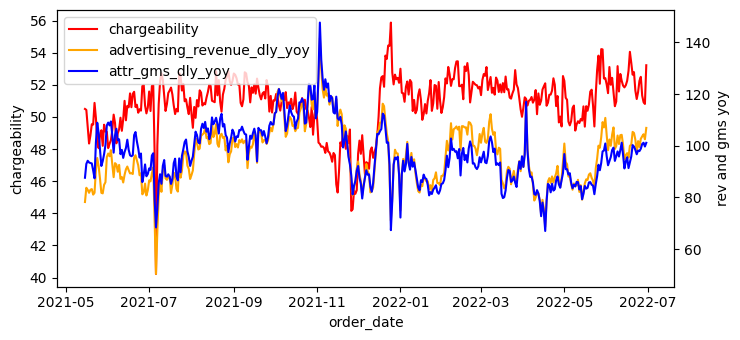

In [174]:
#Display/Pinterest Decel in 2021
#Chargeability vs Att GMS YOY

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

viz_data = base_yoy[(base_ratio_yoy['order_date']>= date.today() - relativedelta(months=15))
&(base_ratio_yoy['order_date'] < date(2022,7,1))&(base_ratio_yoy['order_date'] >= date(2021,5,1))]       

viz_data = viz_data.sort_values(by=['order_date'])

viz_data['takerate'] = (viz_data['attr_receipt']*viz_data['advertising_revenue'])/viz_data['attr_gms']

ax1 = plt.subplot()
l1, = ax1.plot(viz_data['order_date'].array, viz_data['chargeability'].array, color='red')    
ax2 = ax1.twinx()
l2, = ax2.plot(viz_data['order_date'].array, viz_data['advertising_revenue_dly_yoy'].array, color='orange')
#advertising_revenue_dly_yoy
l3, = ax2.plot(viz_data['order_date'].array, viz_data['attr_gms_dly_yoy'].array, color='blue')

plt.legend([l1, l2,l3], ["chargeability", "advertising_revenue_dly_yoy","attr_gms_dly_yoy"], loc="upper left")

ax1.set_xlabel('order_date')
ax1.set_ylabel('chargeability')
ax2.set_ylabel('rev and gms yoy')

plt.show()

In [ ]:
#MODEL BUILDING FROM HERE ON AND SO FORTH

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
    
metrics_index = (base_ratio_yoy.columns.values.tolist()).index("attr_gms")
group_by_col = (base_ratio_yoy.columns.values.tolist())[:metrics_index ]
exclude_col = ['order_date','order_year', 'order_week_num', 'order_dayofyear']
#exclude_dates = [date(2021, 12, 31)]

#get metrics with yoy stats
metrics = {'chargeable_aov':['d2ly_yoy_diff'],'aov':'','attr_gms':['d2ly_yoy'],'days_since_purchase_1 - 15':'','pct_receipts_1 - 15':'','attr_receipts_osa_revenue':'','attr_receipts_none':'','visits_osa_el_clicks':'','visits_osa_el_shops':''}

model_features = []

for item in metrics.keys():
    
    print(item)
    
    if item not in ['chargeable_aov']:
    
        model_features = model_features + [item]
    
    
    if metrics[item] != '':
        
        print(metrics[item])
    
        for i in metrics[item]:
        
            model_features = model_features + [item + '_' + i]
        
print(model_features)

#get model data: data from the past 12 months from OSA channels

model_base = base_ratio_yoy.loc[(base_ratio_yoy['order_date'] >= date.today() - relativedelta(months=12))&(base_ratio_yoy['order_date'] < date(2022,7,1)), group_by_col + model_features + ['chargeability']]

#model_base = model_base[~model_base.order_date.isin(exclude_dates)]

model_base.fillna(0, inplace= True)

#one hot encode categorical variables 
dummy_results = pd.get_dummies(model_base[['order_year']])

model_base = pd.concat([model_base,dummy_results], axis = 1)

#set columns to be excluded from training data to index
model_base.set_index(exclude_col,inplace=True)

chargeable_aov
['d2ly_yoy_diff']
aov
attr_gms
['d2ly_yoy']
days_since_purchase_1 - 15
pct_receipts_1 - 15
attr_receipts_osa_revenue
attr_receipts_none
visits_osa_el_clicks
visits_osa_el_shops
['chargeable_aov_d2ly_yoy_diff', 'aov', 'attr_gms', 'attr_gms_d2ly_yoy', 'days_since_purchase_1 - 15', 'pct_receipts_1 - 15', 'attr_receipts_osa_revenue', 'attr_receipts_none', 'visits_osa_el_clicks', 'visits_osa_el_shops']


In [154]:
model_base.head()

,,,,chargeable_aov_d2ly_yoy_diff,aov,attr_gms,attr_gms_d2ly_yoy,days_since_purchase_1 - 15,pct_receipts_1 - 15,attr_receipts_osa_revenue,attr_receipts_none,visits_osa_el_clicks,visits_osa_el_shops,chargeability,order_year_2021-01-01,order_year_2022-01-01
order_date,order_year,order_week_num,order_dayofyear,,,,,,,,,,,,,
2022-04-06,2022-01-01,14,96,22.987865736,33.134731804,5517213.553612762,165.588243494,6.004676939,0.458081512,0.584302500,0.202705873,1.001557923,13.921450602,51.064629140,0,1
2022-04-07,2022-01-01,14,97,23.104028168,33.232224541,5363846.436217130,148.714395102,5.985206637,0.456976364,0.584302500,0.202705873,0.999128777,13.804975239,51.239959098,0,1
2022-04-03,2022-01-01,14,93,24.428670500,33.952934918,6265713.779911059,180.460105931,5.877573585,0.473064942,0.584302500,0.202705873,0.980912021,15.179842996,51.124916051,0,1
2022-04-09,2022-01-01,14,99,18.354359636,33.224785000,5065249.459582574,130.858342148,5.952681604,0.462004856,0.584302500,0.202705873,0.986656005,13.963945421,51.075364020,0,1
2022-04-08,2022-01-01,14,98,23.265364143,33.757169453,5236280.004243574,136.429146801,6.038791877,0.454233883,0.584302500,0.202705873,1.002317143,13.527406055,50.887016887,0,1


In [126]:
model_base.corr().to_csv('chargeability_model_base_corr.csv')

#last step

In [155]:
print(model_base.sum())

chargeable_aov_d2ly_yoy_diff         1282.316565328
aov                                 10418.305787028
attr_gms                       1842454860.053867340
attr_gms_d2ly_yoy                   28420.601787765
days_since_purchase_1 - 15           1864.758560464
pct_receipts_1 - 15                   160.021131943
attr_receipts_osa_revenue             189.728785164
attr_receipts_none                     67.513097281
visits_osa_el_clicks                  326.802120948
visits_osa_el_shops                  4627.607792651
chargeability                       16473.740178926
order_year_2021-01-01                 142.000000000
order_year_2022-01-01                 181.000000000
dtype: float64


In [156]:
x_train,x_test,y_train,y_test=train_test_split(model_base.loc[:,~model_base.columns.isin(['chargeability'])],model_base['chargeability'],test_size=0.2,random_state=0)


In [157]:
linreg=LinearRegression()
linreg.fit(x_train,y_train)
y_pred=linreg.predict(x_test)

print('Coefficients: ', linreg.coef_)
  
print('Variance score: {}'.format(linreg.score(x_test, y_test)))

feature_importance = pd.DataFrame(zip(np.array([item for item in model_base.columns.values if item != 'chargeability']) , linreg.coef_), columns=['Feature','Coefficient'])

print(feature_importance )

Coefficients:  [ -0.00634729  -0.38777678  -0.00000089   0.00314602  -1.84190606
  -1.40533892  13.82567075 -47.98578722 -29.51081294   0.18604379
   0.37078374  -0.37078374]
Variance score: 0.7485647330463558
                         Feature   Coefficient
0   chargeable_aov_d2ly_yoy_diff  -0.006347285
1                            aov  -0.387776781
2                       attr_gms  -0.000000885
3              attr_gms_d2ly_yoy   0.003146019
4     days_since_purchase_1 - 15  -1.841906061
5            pct_receipts_1 - 15  -1.405338917
6      attr_receipts_osa_revenue  13.825670746
7             attr_receipts_none -47.985787220
8           visits_osa_el_clicks -29.510812936
9            visits_osa_el_shops   0.186043788
10         order_year_2021-01-01   0.370783737
11         order_year_2022-01-01  -0.370783737


In [158]:
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RSME = mean_squared_error(y_test, y_pred)

print('R2: {}'.format(R2))
print('MAE: {}'.format(MAE))
print('RSME: {}'.format(RSME))

R2: 0.7485647330463558
MAE: 0.6552438728384558
RSME: 0.6551920599726025


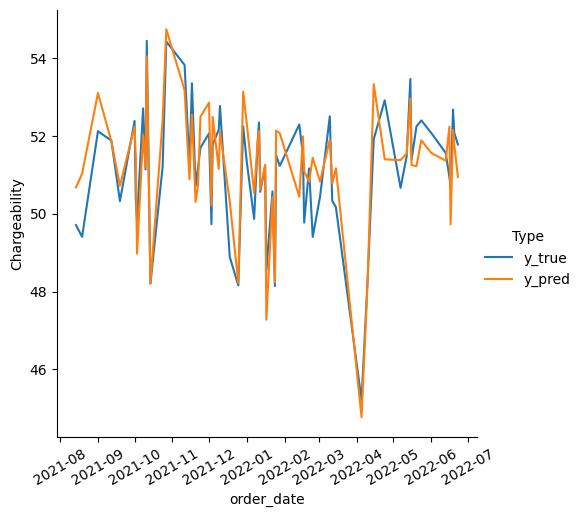

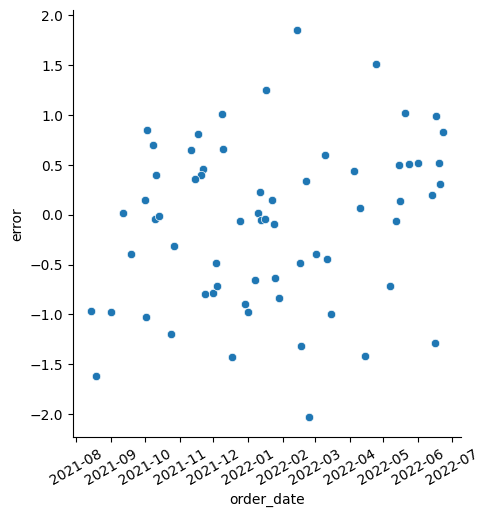

In [159]:
result = pd.DataFrame(zip(y_test,y_pred), columns = ['y_true','y_pred'])

result['error'] = (result['y_true'] - result['y_pred'])

viz_result = pd.concat([x_train.reset_index(), result] ,axis = 1)

viz_result_pivot = pd.melt(viz_result,
    id_vars=[item for item in viz_result.columns if item not in ['y_true','y_pred']], 
    var_name="Type", value_name="Chargeability")

#sns.lineplot(data=viz_result_pivot, x="order_date", y="Value", hue="Type", col="reporting_channel_group_engine")

viz = sns.relplot(
    data=viz_result_pivot, x="order_date", y="Chargeability", hue="Type", kind="line"
)

viz.set_xticklabels(rotation=30)

viz2 = sns.relplot(
    data=viz_result_pivot, x="order_date", y="error",
)

viz2.set_xticklabels(rotation=30)


In [137]:
viz_result.head()

,order_date,order_year,order_week_num,order_dayofyear,chargeable_aov_dly_yoy,chargeable_aov_d2ly_yoy,aov,attr_gms,attr_gms_d2ly_yoy,days_since_purchase_1 - 15,pct_receipts_1 - 15,attr_receipts_osa_revenue,attr_receipts_none,visits_osa_el_clicks,visits_osa_el_shops,order_year_2021-01-01,y_true,y_pred,error
0,2022-06-23,2022-01-01,25,174,92.065026956,107.803179598,31.940524456,3883215.022239629,92.296087199,5.871060871,0.490490033,0.591289369,0.201621541,1.021237467,11.595650341,0,51.779714807,50.766362933,1.013351874
1,2021-12-25,2021-01-01,51,359,87.725185782,0.000000000,30.393062120,3125431.012023671,0.000000000,5.732308997,0.468426273,0.576789061,0.187766691,1.038743713,14.640087552,1,48.160334798,48.204663694,-0.044328896
2,2021-10-01,2021-01-01,39,274,116.196648048,0.000000000,32.301744102,5252489.677373853,0.000000000,5.904565818,0.499099836,0.592538388,0.219601883,1.023792065,12.873361017,1,52.385344622,52.258107570,0.127237052
3,2021-09-01,2021-01-01,35,244,114.934475580,0.000000000,32.576458913,4896972.966334931,0.000000000,5.871750101,0.503915168,0.579766293,0.202315497,1.011901785,12.935398706,1,52.121576044,52.978040290,-0.856464247
4,2022-04-05,2022-01-01,14,95,96.073344056,146.400665333,33.470824148,5705232.927225456,175.647452356,6.004542181,0.460361869,0.584302500,0.202705873,1.000948855,14.186341814,0,45.214940624,44.884943557,0.329997067


In [ ]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))

plt.text(0.6, 0.5, 'R-squared = %0.2f' % R2)
plt.show()

In [160]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(np.asarray(x_train.astype(int)))
est = sm.OLS(np.asarray(y_train.astype(int)), X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     101.5
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           6.54e-74
Time:                        19:44:05   Log-Likelihood:                -332.08
No. Observations:                 258   AIC:                             682.2
Df Residuals:                     249   BIC:                             714.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.7285      1.601     27.313      0.0

In [141]:
model_base.to_csv('model_base.csv')